## **Libraries**

We begin by importing the Python libraries required to build and evaluate a traditional machine learning model.

We will be using:
* **pandas** for loading and exploring the dataset
* **NumPy** for numerical operations
* **scikit-learn** for model training and evaluation
* **matplotlib** for visualisation

All libraries and their versions will be listed in the 'requirements.txt' file to ensure reproducibility of the analysis.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt

## **Loading the Dataset**

The dataset used here contains confirmed and candidate exoplanets, along with a range of observational features collected from the Kepler Space Telescope.

We load the dataset using pandas and take an initial look at its structure to better understand the available features and target labels. This step helps us identify the relevant columns and check for missing values or anomalies before building our model.

In [ ]:
# Load the dataset
df = pd.read_csv(r"C:\Exoplanet-search\archive\cumulative.csv")

# Set pandas display options to make debugging easier
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Display the first few rows of the dataset
df.head()

## **Selecting Features and Target**

Next, we define which columns will be used as **features**.

We select fatures which describe:
* **Stellar parameters**: properties of the host star, which can influence transit measurements
* **Planetary candidate paramters**: properties of the transit itself, which are directly related to the likelihood of a planet being real

The target variable is 'koi_disposition', which categorises each candidate as **CONFIRMED**, **CANDIDATE**, or **FALSE POSITIVE**.

In [ ]:
# Features to use for classification
features = [
    # STELLAR PARAMETERS
    "koi_steff",      # Stellar effective temperature (K) - hotter/cooler stars affect detectability
    "koi_slogg",      # Stellar surface gravity (log10(cm/s^2)) - affects transit light curve
    "koi_srad",       # Stellar radius (Solar radii) - influences transit depth and duration
    # PLANETARY CANDIDATE PARAMETERS
    "koi_period",     # Orbital period (days) - longer or shorter period can indicate different candidate likelihoods
    "koi_duration",   # Transit duration (hours) - helps distinguish between planetary transits and false positives
    "koi_depth",      # Transit depth (ppm) - deeper transits may indicate larger planets or false positives
    "koi_prad",       # Planetary radius (Earth radii) - size can influence classification
]

# Target variable
target = 'koi_disposition'

## **Handling Missing Values**

Machine learning models generally cannot handle missing values, so we need to address them before training our model.

We start be checking how many missing values exist in each feature and in the target variable. This helps us understand the quality of the dataset and decide how to handle incomplete rows.

There are two common approaches for handling missing data:
1. **Dropping rows with missing values**
   * Simple to implement and ensures the model only sees complete data
   * Reduces dataset size, if missingness is systematic, it can bias the model
2. **Imputation (mean/median/mode)**
   * Keeps more data and reduces the bias if done carefully
   * Introduces artifical values and can be more complex

Since the percentage of missing data is small in this dataset, we will drop rows with missing values.

In [1]:
# Check for missing values in each column
missing_values = df[features + [target]].isna().sum()
print("Missing values in each column:\n", missing_values)

# Calculate percentage of missing values
missing_percentage = (missing_values / len(df)) * 100
print("\nPercentage of missing values in each column:\n", missing_percentage)

# Drop rows with missing values in features or target
df_ml = df[features + [target]].dropna()
print(f"Rows after dropping NaNs:", len(df_ml))

NameError: name 'df' is not defined

After dropping rows with missing values, we are left with 9,201 samples.

This ensures that the Decision Tree model can be trained without encountering errors due to NaNs. It also keeps the dataset large enough for the model to learn meaningful patterns.

In [ ]:
# Map classes to integer values

# Decision Tree models require numerical target values, so we need to
# convert the string labels in 'koi_disposition' to integers so the model
# can understand them.

target_mapping = {
    'CONFIRMED': 1, # Assign 1 to confirmed planets
    'CANDIDATE': 0, # Assign 0 to candidate planets
    'FALSE POSITIVE': -1 # Assign -1 to false positives
}

# Replace the string labels in the target column with integers
df_ml[target] = df_ml[target].replace(target_mapping)

In [ ]:
# Drop any rows where replace failed

# After replacing string labels with integers, there might be
# some unexpected values that didn't get mapped. These will become NaN.

# dropna(subset=[target]) to remove rows where target is NaN. In this dataset.
# we expect this to drop very few or no rows.

df_ml = df_ml.dropna(subset=[target])  # Shouldn't normally drop anything now

# Print the number of remaining rows
print("Rows after mapping drop:", len(df_ml))

Rows after mapping drop: 9201


In [ ]:
# Separate features and target variable

# X will contain the values of the feature columns. This is what the model
# will use to learn patterns.
X = df_ml[features].values

# y will contain the values of the target column. This is what the model
# is trying to predict.
y = df_ml[target].values

# Decision Tree models expect two seperate arrays: one for input features (X)
# and one for target labels (y).

#.values converts the DataFrame columns to NumPy arrays, which sklearn
# works with.

In [ ]:
# Scale features (standardisation)

# Rescale features to have mean 0 and standard deviation 1.
# This is important because features are on different scales (e.g.,
# temperature in Kelvin vs. radius in Earth radii). Scaling helps the
# model learn more effectively.

scaler = StandardScaler() # Create a StandardScaler object
X_scaled = scaler.fit_transform(X) # Fit scaler to X and transform X

# After this:
# Each feature in X_scaled will have mean approximately 0 and standard deviation 1.
# Helps the model converge faster and perform better.

In [ ]:
# Split the dataset into training and test sets

# Divide the dataset so that the model learns patterns on the training set.
# Then we can evaluate how well it learned by testing on the test set.

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, # Features
    y, # Target
    test_size= 0.2, # 20% of data for testing
    random_state= 42, # Ensures reproducible splits
    stratify = y # Maintain class distribution in train/test splits
)

# Print the number of samples in each set
print("Training samples:", len(X_train))
print("Test samples:", len(X_test))

# stratify = y ensures all three classes are represented proportionally in both sets.
# Without stratification, random splits might lead to imbalanced classes.

Training samples: 7360
Test samples: 1841


In [ ]:
# Decision Tree Classifier

# Create the Decision Tree model with specified parameters
# criterion = "entropy" gives splits that maximize information gain.
# max_depth = 5 prevents the tree from growing too deep and overfitting.
# random_state = 42 ensures reproducible results.

model = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=5,
    random_state=42
)

# Train (fit) the model on the training data
# X_train: feature values for training
# y_train: corresponding labels for training
model.fit(X_train, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
# Predict the target labels for the test set
y_pred = model.predict(X_test)

# Accuracy score: fraction of correct predictions
# Accuracy = (Number of correct predictions) / (Total number of predictions)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix: shows counts of
# - True Positives (correctly predicted CONFIRMED)
# - True Negatives (correctly predicted CANDIDATE or FALSE POSITIVE)
# - Misclassifications
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification Report: provides detailed metrics for each class
# Includes:
# - Precision: proportion of predicted positives that are correct
# - Recall: proportion of actual positives that were correctly predicted
# - F1-score: harmonic mean of precision and recall
# - Support: number of samples for each class
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Accuracy gives a quick overall performance check.
# Confusion matrix helps see which classes the model struggles with.
# Classification reports provides per class metrics for deeper insights.

# So 65.5% of the time, the model correctly predicts whether a planet
# is CONFIRMED, CANDIDATE, or FALSE POSITIVE.

# From the classification report (%):

# Precision: How many predicted class were actually correct?
# - FALSE POSITIVE (-1): 0.82 which is quite good.
# - CANDIDATE (0): 0.43 which is moderate.
# - CONFIRMED (1): 0.56 which is decent.

# Recall: How many actual class instances were correctly predicted?
# - FALSE POSITIVE (-1): 0.76 which is good.
# - CANDIDATE (0): 0.38 which is low, meaning the model misses many.
# - CONFIRMED (1): 0.69 which is decent.

# F1-score: Balance between precision and recall.
# - FALSE POSITIVE (-1): 0.79 which is good.
# - CANDIDATE (0): 0.41 which is low.
# - CONFIRMED (1): 0.62 which is decent.

# Support: Number of samples in each class.

# The model detects FALSE POSITIVEs best, but struggles with CANDIDATEs.
# Accuracy is okay, but imbalanced classes likely affect performance.
# Decision Tree depth, feature selection, and more data could improve results.

Accuracy: 0.6561651276480174

Confusion Matrix:
 [[721 118 106]
 [123 168 146]
 [ 38 102 319]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.82      0.76      0.79       945
           0       0.43      0.38      0.41       437
           1       0.56      0.69      0.62       459

    accuracy                           0.66      1841
   macro avg       0.60      0.61      0.61      1841
weighted avg       0.66      0.66      0.66      1841



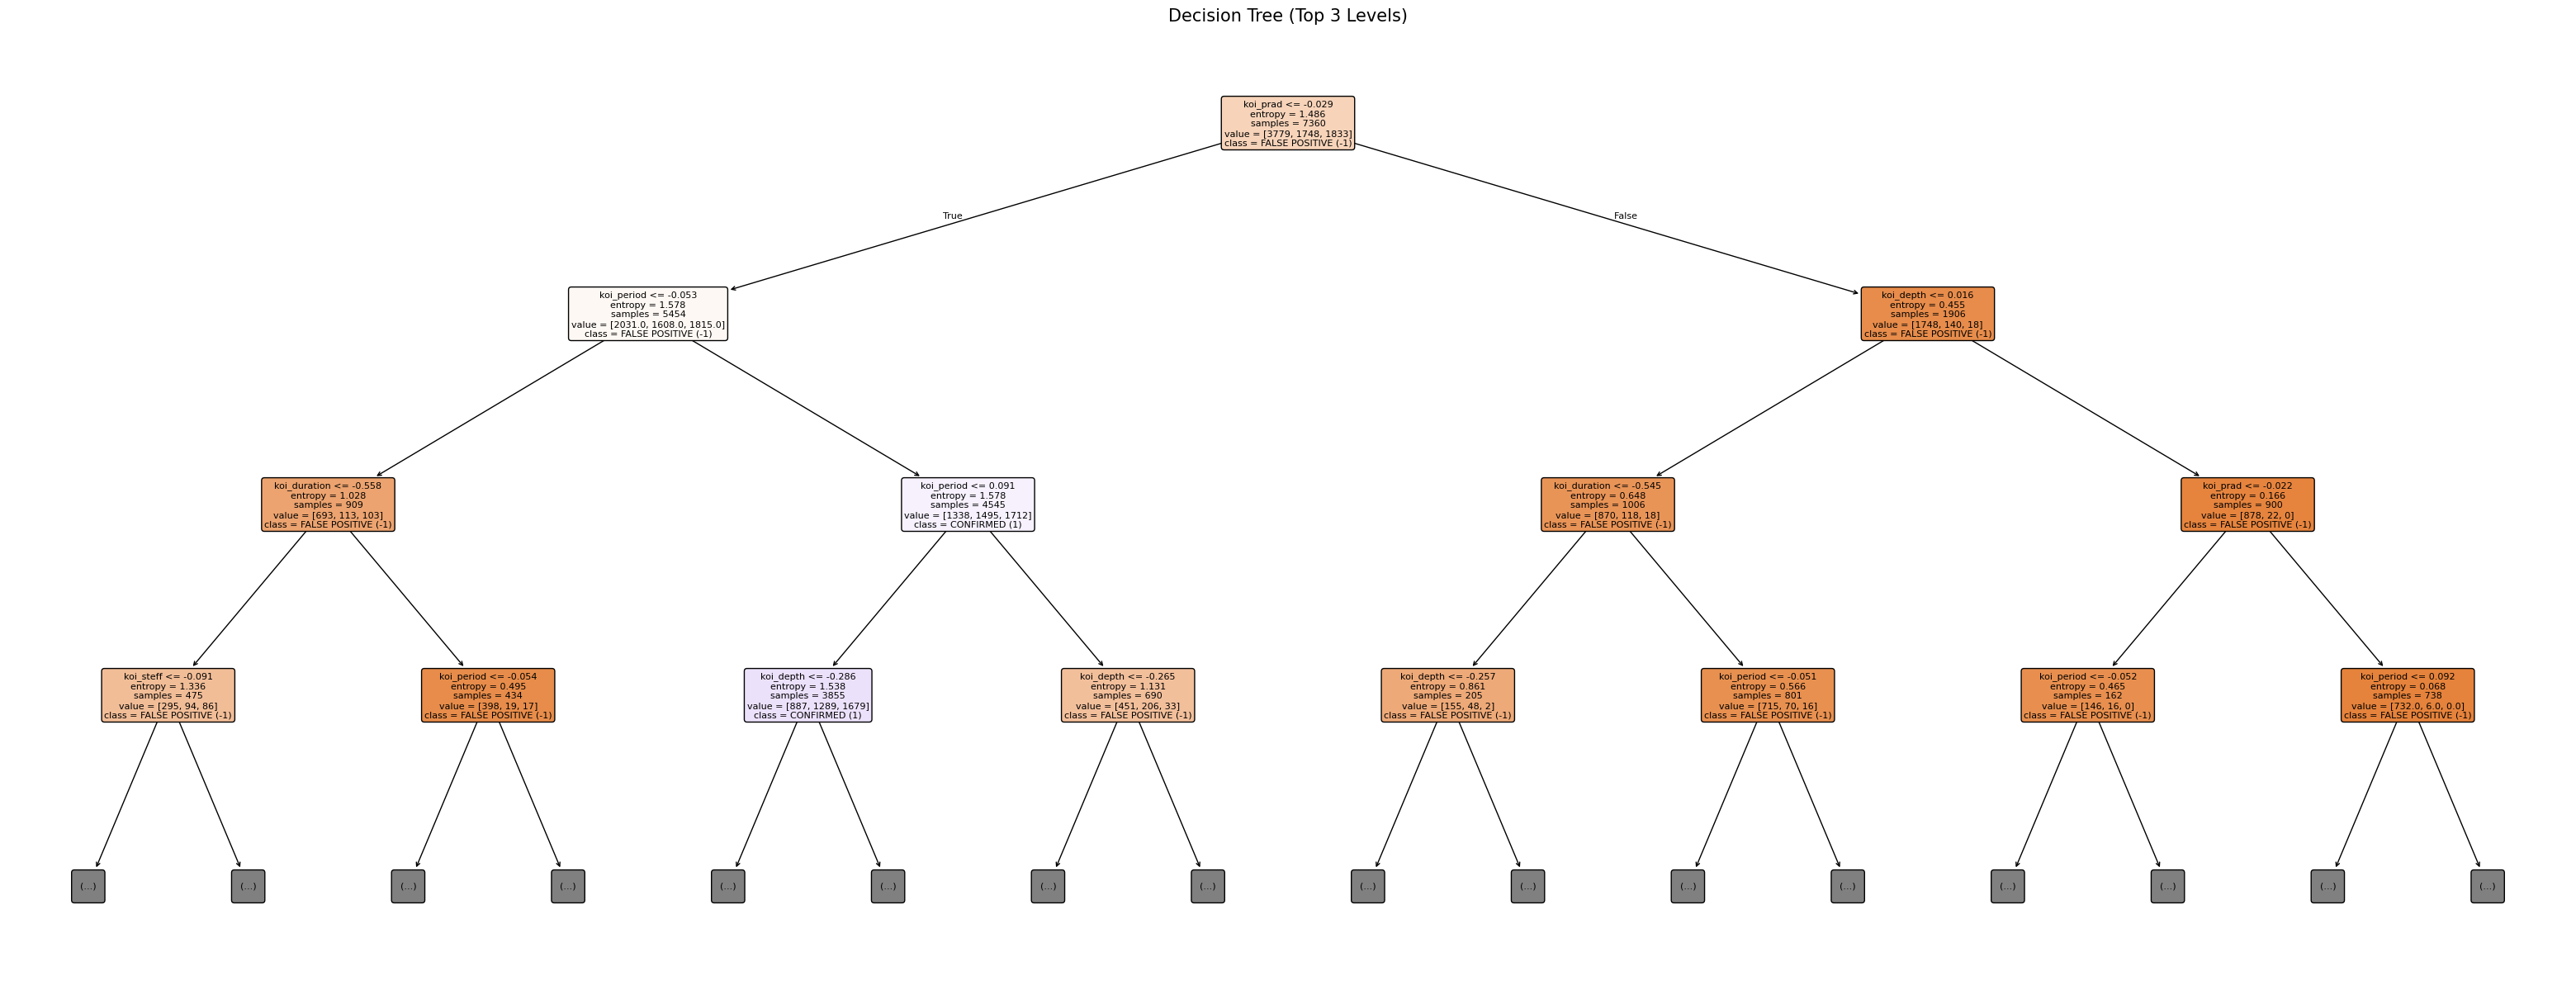

In [ ]:
# Plot the Decision Tree

# Set the figure size for clarity
plt.figure(figsize=(40, 15))

# plot_tree() visualises the structure of the trained Decision Tree model.
plot_tree(
    model, # The trained Decision Tree model
    feature_names = features, # Column names for features
    class_names=["FALSE POSITIVE (-1)", "CANDIDATE (0)", "CONFIRMED (1)"], # Class labels
    filled = True, # Colour nodes based on class
    rounded = True, # Rounded node boxes for aesthetics
    max_depth = 3 # Only show top 3 levels of the tree for readability
)

# Add title
plt.title("Decision Tree (Top 3 Levels)", fontsize=15)

# Display
plt.show()

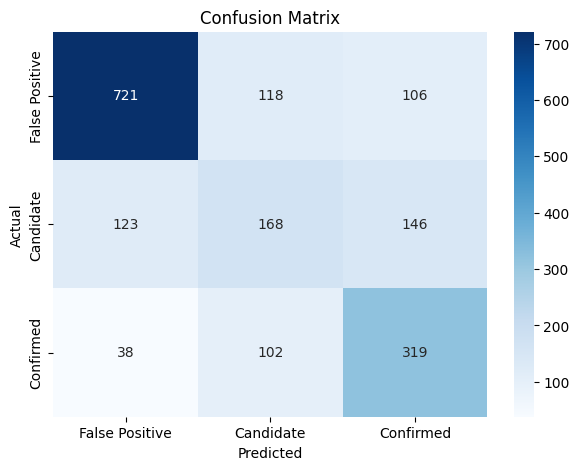

In [ ]:
# Plot the confusion matrix as a heatmap

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Set figure size
plt.figure(figsize=(7, 5))

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, # The confusion matrix
            annot = True, # Show numbers in each cell
            fmt = "d", # Display numbers as integers
            cmap = "Blues", # Colour map
            xticklabels=["False Positive", "Candidate", "Confirmed"], # Column labels
            yticklabels=["False Positive", "Candidate", "Confirmed"]) # Row labels

# Label axes
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Add title
plt.title("Confusion Matrix")

# Display
plt.show()